Dependency importation

You are given a data of US Airline tweets and their sentiment. The task is to do sentiment analysis about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

In [20]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

Reading and loading the dataset

In [21]:
df= pd.read_csv("Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Exploratory Data Analysis

In [22]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [23]:
df.shape

(14640, 15)

data information

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

Datatypes of all columns

In [25]:
df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

Checking for null values

In [26]:
np.sum(df.isnull().any(axis=1))

14638

In [27]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [38]:
#Deleting columns that don't contribute to our analysis
del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24,NaN,Pacific Time (US & Canada)


In [39]:
freq = df.groupby('negativereason').size()
freq

negativereason
Bad Flight                      580
Can't Tell                     1190
Cancelled Flight                847
Customer Service Issue         2910
Damaged Luggage                  74
Flight Attendant Complaints     481
Flight Booking Problems         529
Late Flight                    1665
Lost Luggage                    724
longlines                       178
dtype: int64

we cant fill it will affect in bad way for example we have positive reviwe and we fill the values with mode that means with Customer Service Issue it is missmatch and can be affect on train model so we keep the data as it is.

In [28]:
#checking last 5 entries
df.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


changing tweet created to from object to datetype 

In [29]:
df['tweet_created'] = pd.to_datetime(df['tweet_created']).dt.date

In [35]:
df['tweet_created'] = pd.to_datetime(df['tweet_created'])

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   tweet_id                      14640 non-null  int64         
 1   airline_sentiment             14640 non-null  object        
 2   airline_sentiment_confidence  14640 non-null  float64       
 3   negativereason                9178 non-null   object        
 4   negativereason_confidence     10522 non-null  float64       
 5   airline                       14640 non-null  object        
 6   airline_sentiment_gold        40 non-null     object        
 7   name                          14640 non-null  object        
 8   negativereason_gold           32 non-null     object        
 9   retweet_count                 14640 non-null  int64         
 10  text                          14640 non-null  object        
 11  tweet_coord                 

number of tweets created between 16 and 24

In [37]:
numberoftweets = df.groupby('tweet_created').size()
numberoftweets

tweet_created
2015-02-16       4
2015-02-17    1408
2015-02-18    1344
2015-02-19    1376
2015-02-20    1500
2015-02-21    1557
2015-02-22    3079
2015-02-23    3028
2015-02-24    1344
dtype: int64

Exploratory Data Analysis

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive'), Text(2, 0, 'Neutral')]

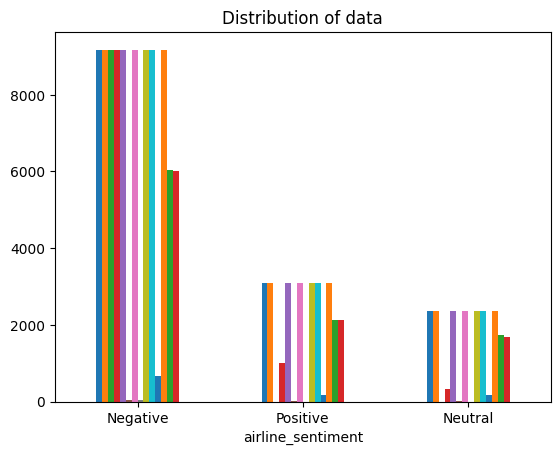

In [31]:
# Plotting the distribution for dataset.
ax = df.groupby('airline_sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive','Neutral'], rotation=0)


Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


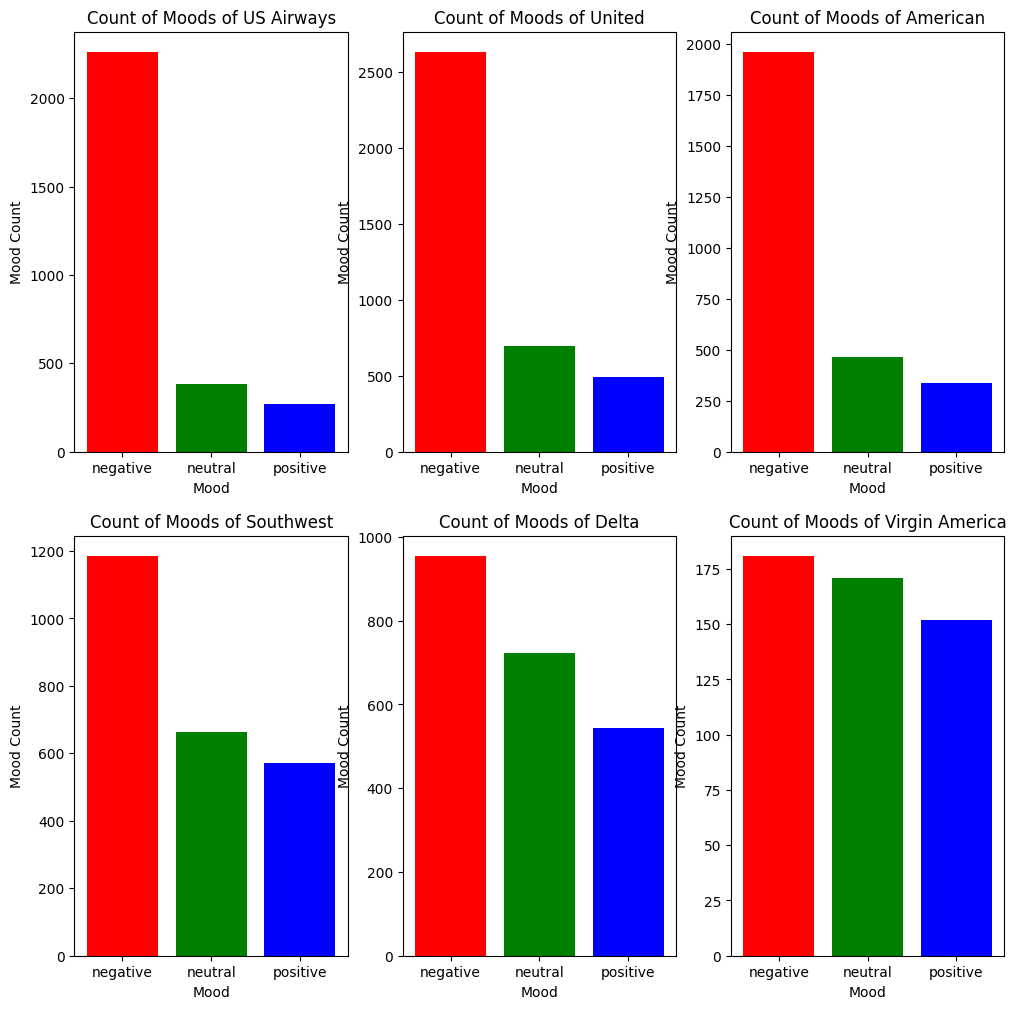

In [41]:
print("Total number of tweets for each airline \n ",df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=df[df['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

Looks like people are not having pleasant flights these days. It is important to know which airline pleases their costumers the most and vice versa, so we sill be looking at the percentage of the negative reviews for each airline.

C:\Users\USER\AppData\Local\Temp\ipykernel_14564\663527633.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  my_dict = {'American':neg_tweets[0] / total_tweets[0],'Delta':neg_tweets[3] / total_tweets[1],'Southwest': neg_tweets[6] / total_tweets[2],
C:\Users\USER\AppData\Local\Temp\ipykernel_14564\663527633.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'US Airways': neg_tweets[9] / total_tweets[3],'United': neg_tweets[12] / total_tweets[4],'Virgin': neg_tweets[15] / total_tweets[5]}


            Percent Negative
American            0.710402
Delta               0.429793
Southwest           0.490083
US Airways          0.776862
United              0.688906
Virgin              0.359127


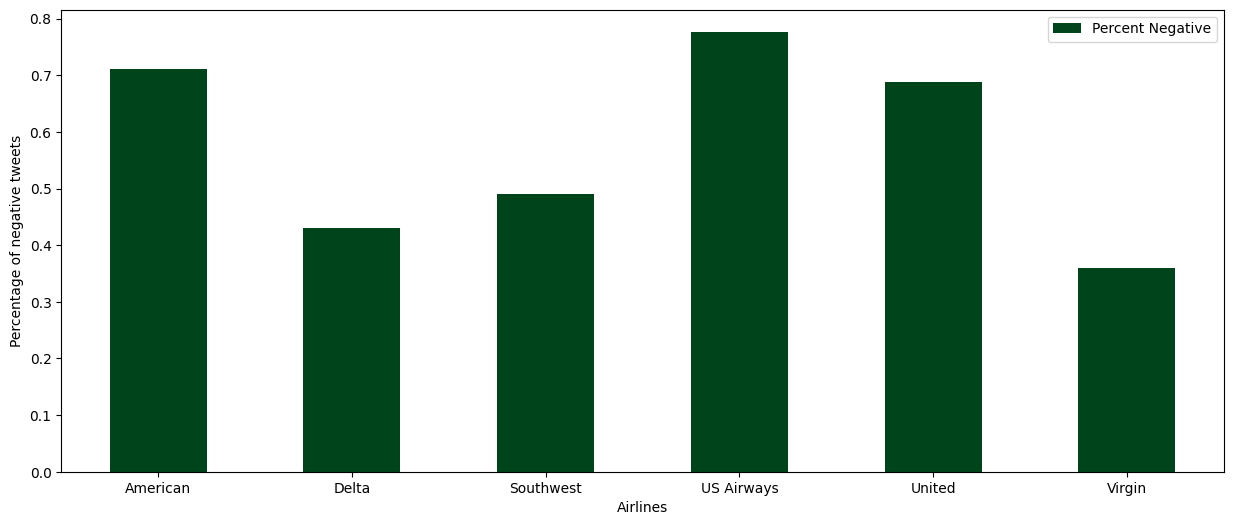

In [42]:
neg_tweets = df.groupby(['airline','airline_sentiment']).count().iloc[:,0]
total_tweets = df.groupby(['airline'])['airline_sentiment'].count()

my_dict = {'American':neg_tweets[0] / total_tweets[0],'Delta':neg_tweets[3] / total_tweets[1],'Southwest': neg_tweets[6] / total_tweets[2],
'US Airways': neg_tweets[9] / total_tweets[3],'United': neg_tweets[12] / total_tweets[4],'Virgin': neg_tweets[15] / total_tweets[5]}
perc = pd.DataFrame.from_dict(my_dict, orient = 'index')
perc.columns = ['Percent Negative']
print(perc)
ax = perc.plot(kind = 'bar', rot=0, colormap = 'Greens_r', figsize = (15,6))
ax.set_xlabel('Airlines')
ax.set_ylabel('Percentage of negative tweets')
plt.show()

United, US Airways, American substantially get negative reactions.
Tweets for Virgin America are the most balanced

<Axes: xlabel='airline'>

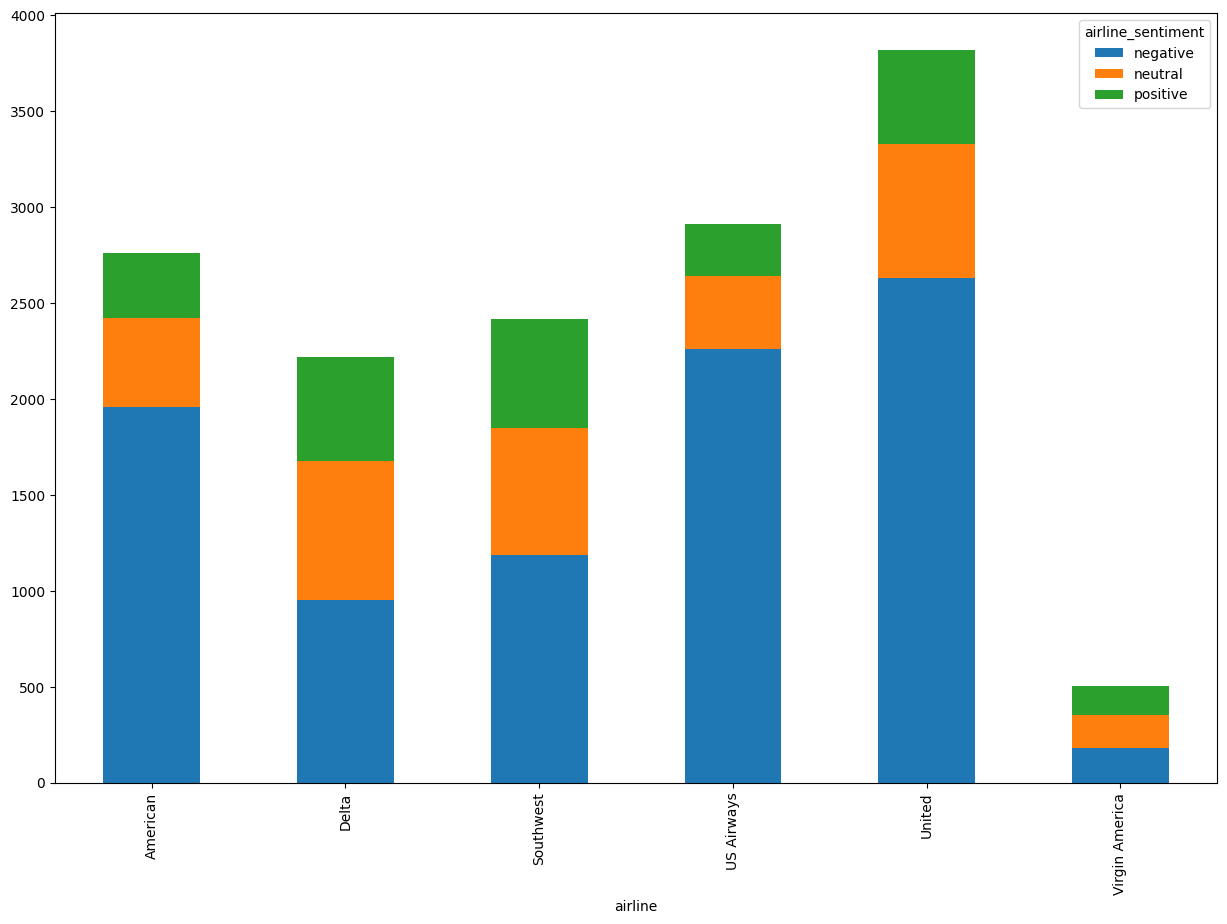

In [44]:
figure_2 = df.groupby(['airline', 'airline_sentiment']).size()
figure_2.unstack().plot(kind='bar', stacked=True, figsize=(15,10))

In [32]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [33]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
C:\Users\USER\AppData\Local\Temp\ipykernel_14564\2426161746.py:9: SyntaxWarning: invalid escape sequence '\s'
  userPattern       = '@[^\s]+'


In [34]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

NameError: name 'text' is not defined